# ECE 197-Z [Project 1]
By: Gabriel Enrique N. Kaquilala (2019-06319)

Requirements:

    - mscoco2017plus1_labels.txt in the current working directory
        = Included in repo.

    - instances_val2017.json stored in a sub-directory named "annotations"
        = Download link: http://images.cocodataset.org/annotations/annotations_trainval2017.zip

    - Required Python packages:
        = pip install opencv-python pycocotools matplotlib onnxruntime onnx pillow tritonclient open-clip-torch segment-anything numpy opencv-python validators matplotlib torch

In [1]:
# ---------------------------------------
# Import libraries
from PIL import Image
import json, random, os, cv2, time, numpy as np
import matplotlib.pyplot as plt
import validators, urllib.request
# ---------------------------------------
# Import helper functions 
import SAM_A100         # For those with slow / no GPUs
import OpenCLIPLocal    # Used for local OpenCLIP inferences
from pytriton.client import ModelClient # Used for YOLO reference
# ---------------------------------------

# ---------------------------------------
# Import json data for random images
current_path = os.getcwd()
with open(os.path.join(current_path,'annotations',"instances_val2017.json"),'r') as json_file:
    validation_json = json.load(json_file)
    images = validation_json['images']
# ---------------------------------------

# ---------------------------------------
# Set to cuda or CPU depending user preference
OpenCLIP_device = 'cuda'            # No Online OpenCLIP inference. Algorithm uses OpenCLIP confidence.
# ---------------------------------------

# ---------------------------------------
# Initiate OpenCLIP
OpenCLIPLocal.init_OpenCLIP(OpenCLIP_device)    # Requires ~4GB of VRAM.
# ---------------------------------------

/home/gabriel/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Intializing OpenCLIP...


# SAM and OpenCLIP Filter Parameters:


In [6]:
# ---------------------------------------
# SAM Filter Parameters                                                                             [Default Values]
parameter_ss_cutoff = 0.9               # Stability score cutoff.                                       [0.900]
parameter_p_iou_cutoff = 0.9            # Predicted IoU cutoff.                                         [0.900]
parameter_area_cutoff = 0.000           # Cutoff for mask area relative to bbox.                        [0.000]
parameter_area_cutoff_global = 0.000    # Cutoff for extremely small objects relative to whole image.   [0.000]
# ----------------------------------------

# ----------------------------------------
# OpenCLIP Filter Parameters
parameter_confidence_cuttoff = 0.65     # OpenCLIP confidence cutoff                                    [0.650]
parameter_avg_conf_mod = 0.9            # Intersection handler confidence modifier                      [0.900]
parameter_intersection_percent = 0.0    # Cutoff for intersection area w.r.t. smaller bbox.             [0.000]
# ----------------------------------------

Helper Functions:

In [7]:
def is_intersecting(box1_coords, box2_coords):      # Returns if 2 bounding boxes intersect.            [True or False]
    
    ymin1, ymax1, xmin1, xmax1 = box1_coords
    ymin2, ymax2, xmin2, xmax2 = box2_coords
    
    if ((xmax1 >= xmin2) and (xmax2 >= xmin1)) and ((ymax2 >= ymin1) and (ymax1 >= ymin2)):
        return True
    
    return False

def calc_intersection(box1_coords, box2_coords):    # Returns how much of 2 boxes intersect.            [intersection area, %area w.r.t. smaller box]
    
    ymin1, ymax1, xmin1, xmax1 = box1_coords
    ymin2, ymax2, xmin2, xmax2 = box2_coords
    
    delta_x = min(abs(xmax1 - xmin2), abs(xmax2 - xmin1))
    delta_y = min(abs(ymax1 - ymin2), abs(ymax2 - ymin1))
    
    area1 = (ymax1 - ymin1) * (xmax1 - xmin1)
    area2 = (ymax2 - ymin2) * (xmax2 - xmin2)
    
    area = min((area1,area2))
    
    intersection_area = delta_x * delta_y
    
    return (intersection_area, intersection_area / area)
    
def get_new_bbox(box1_coords, box2_coords):         # Produces new bounding box.                        [y_top, y_bottom, x_left, x_right]
    
    ymin1, ymax1, xmin1, xmax1 = box1_coords
    ymin2, ymax2, xmin2, xmax2 = box2_coords
    xmin, xmax, ymin, ymax = 0, 0, 0, 0
    
    ymin = ymin1 if ymin1 < ymin2 else ymin2
    xmin = xmin1 if xmin1 < xmin2 else xmin2
    ymax = ymax1 if ymax1 > ymax2 else ymax2
    xmax = xmax1 if xmax1 > xmax2 else xmax2
    
    return (ymin,ymax,xmin,xmax)

def slice_and_classify(cv2_image):                  # Feed image into SAM and use OpenCLIP to classify. [masks]
    
    # ----------------------------------------
    global parameter_p_iou_cutoff, parameter_ss_cutoff, parameter_area_cutoff, SegmentAnything_use_online # SAM
    global parameter_confidence_cuttoff, parameter_confidence_cuttoff_intersection, parameter_intersection_IoU, parameter_intersection_percent_IoU  # OpenCLIP
    # ----------------------------------------
 
    image = cv2_image
    h, w, _ = image.shape   # Get image dimensions.
    image_area = h * w      
   
    print('Sending to A100...')
    image_masks = SAM_A100.sendto_A100_SAM(image)
    
    crops, skipped_masks = [], 0
    
    # ----------------------------------------
    # SAM
    # ----------------------------------------
    
    t = time.time()
    for mask in image_masks:
        
        x, y, w, h = mask['bbox']
        yt, yb = y, y + h
        xl, xr = x, x + w
        bbox_area = (yb - yt) * (xr - xl)
        
        if bbox_area == 0: # Prevent divide by zero error.
            continue
        
        if ((mask['area'] / bbox_area) < parameter_area_cutoff) or (mask['area'] / image_area < parameter_area_cutoff_global):
            skipped_masks += 1
            continue
        
        if mask['stability_score'] < parameter_ss_cutoff:
            skipped_masks += 1
            continue
        
        if mask['predicted_iou'] < parameter_p_iou_cutoff:
            skipped_masks += 1
            continue
        
        crops.append([image[int(yt):int(yb),int(xl):int(xr)],(int(yt),int(yb),int(xl),int(xr))])
    
    del image_masks # free up space

    # ----------------------------------------
    # OpenCLIP
    # ----------------------------------------
    
    outputs, t = [], time.time()
    for crop_array in crops:
        
        crop = crop_array[0]
        prediction = OpenCLIPLocal.local_openclip_inference(crop)
        label, confidence, index = prediction['label'], prediction['confidence'], prediction['index']
        
        if confidence < parameter_confidence_cuttoff:
            continue # Skip low-confidence.
        
        outputs.append({'label':label,'confidence':confidence,'bbox':crop_array[1], 'index':index})
        
    print('[OpenCLIP] Elapsed:',time.time() - t)
    
    labeled_outputs = {}
    for output in outputs: # Classify labeled outputs.
        if output['label'] == 'unknown':
            continue # Skip unknowns.
        if output['label'] not in labeled_outputs.keys():
            labeled_outputs[output['label']] = [output]
        else:
            labeled_outputs[output['label']].append(output)
    
    keys = labeled_outputs.keys()
    
    for key in keys: # Iterate for each label class.
       
        i, j = 0, 0
        
        while i < (len(labeled_outputs[key])): # We need [i] and [i + 1].
            
            j = 0
            
            while j < (len(labeled_outputs[key])):
                
                if i == j:
                    j += 1
                    continue
                
                try: # Prevent out of range errors.
                    snap_a, snap_b = labeled_outputs[key][i], labeled_outputs[key][j]
                except IndexError:
                    break
                    
                if not is_intersecting(snap_a['bbox'],snap_b['bbox']):
                    j += 1
                    continue
                
                intersection = calc_intersection(snap_a['bbox'],snap_b['bbox'])
                if not ((intersection)[1] >= parameter_intersection_percent):
                    j += 1
                    continue
                
                ytn, ybn, xln, xrn = get_new_bbox(snap_a['bbox'],snap_b['bbox'])
                avg_confidence = (snap_a['confidence'] + snap_b['confidence']) / 2
                crop = cv2_image[ytn:ybn,xln:xrn]
                new = OpenCLIPLocal.local_openclip_inference(crop)
                new['bbox'] = (ytn,ybn,xln,xrn)
                
                if not ((new['confidence'] >= (avg_confidence * parameter_avg_conf_mod)) and (new['label'] == snap_a['label'])):
                    j += 1
                    continue
                
                # Combine the two bounding boxes.
                labeled_outputs[key].pop(i)
                if i > j:
                    labeled_outputs[key].pop(j)
                else:
                    labeled_outputs[key].pop(j-1)
                labeled_outputs[key].append(new)           
                         
                j = 0 # Start from the beginning to re-check interesections.
                
            i += 1
            
    output = []
    for key in keys: # Combines all items from the dictionary of labels to be just one array.
        for item in labeled_outputs[key]:
            output.append(item)
            
    return output

If you would like to upload an image to be used as an input, please place the image URL here accordingly. To return to randomly-chosen COCO2017 images, set the url to an empty string ("").

In [8]:
input_url = ""
upload = False

# ----------------------------------------
if validators.url(input_url):

    print('Upload mode enabled.')
    upload = True
    request = urllib.request.Request(input_url, headers={'User-Agent':'Mozilla/5,0'}) # prevent "forbidden" error.
    with urllib.request.urlopen(request) as url_response:
        img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
        image = cv2.imdecode(img_array, -1)
# ----------------------------------------

# Generating Ground truth, SAM + OpenCLIP, YOLOv8
The following code generates 3 captioned images from top to bottom.

Image #4157 chosen.
Taking data from COCO2017 Validation Data Set and Displaying...
COCO image loaded.
Executing SAM + OpenCLIP Inference...
Sending to A100...
[SAM] Elapsed: 3.4208691120147705
[OpenCLIP] Elapsed: 16.472493886947632
Sending data to YOLOv8 Triton Server...


<Figure size 2000x2000 with 0 Axes>

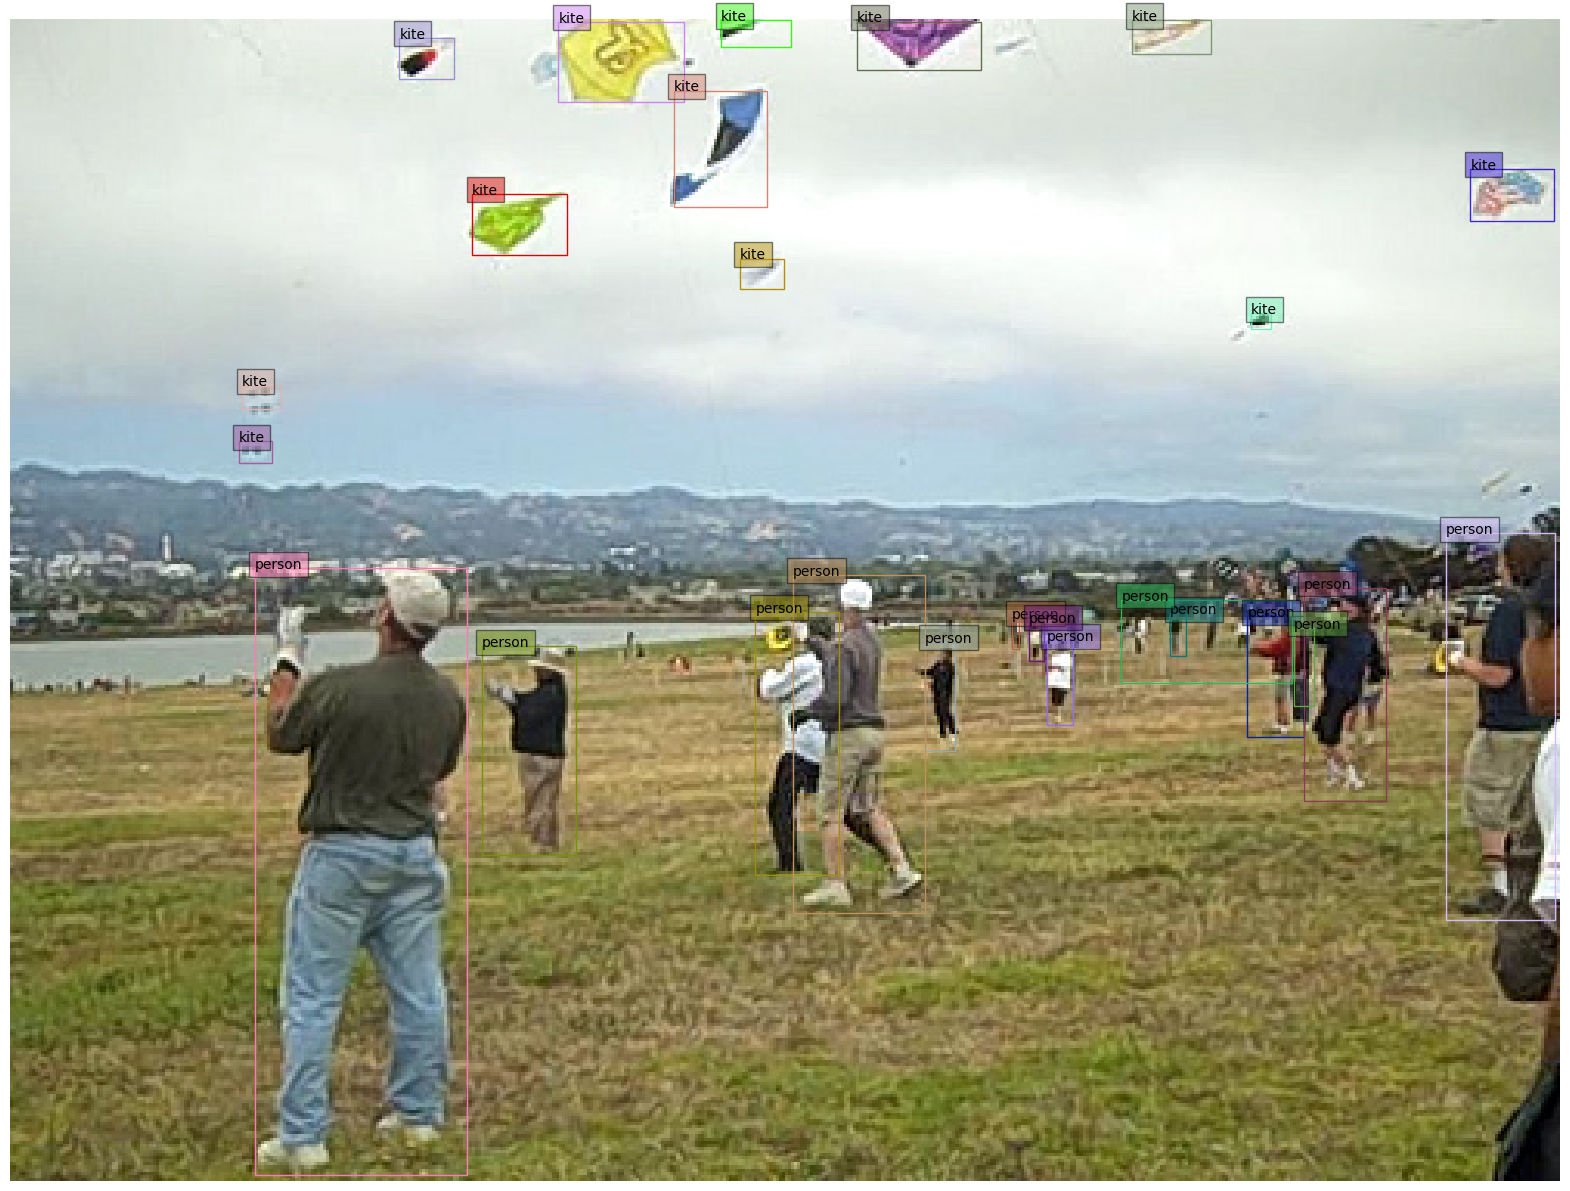

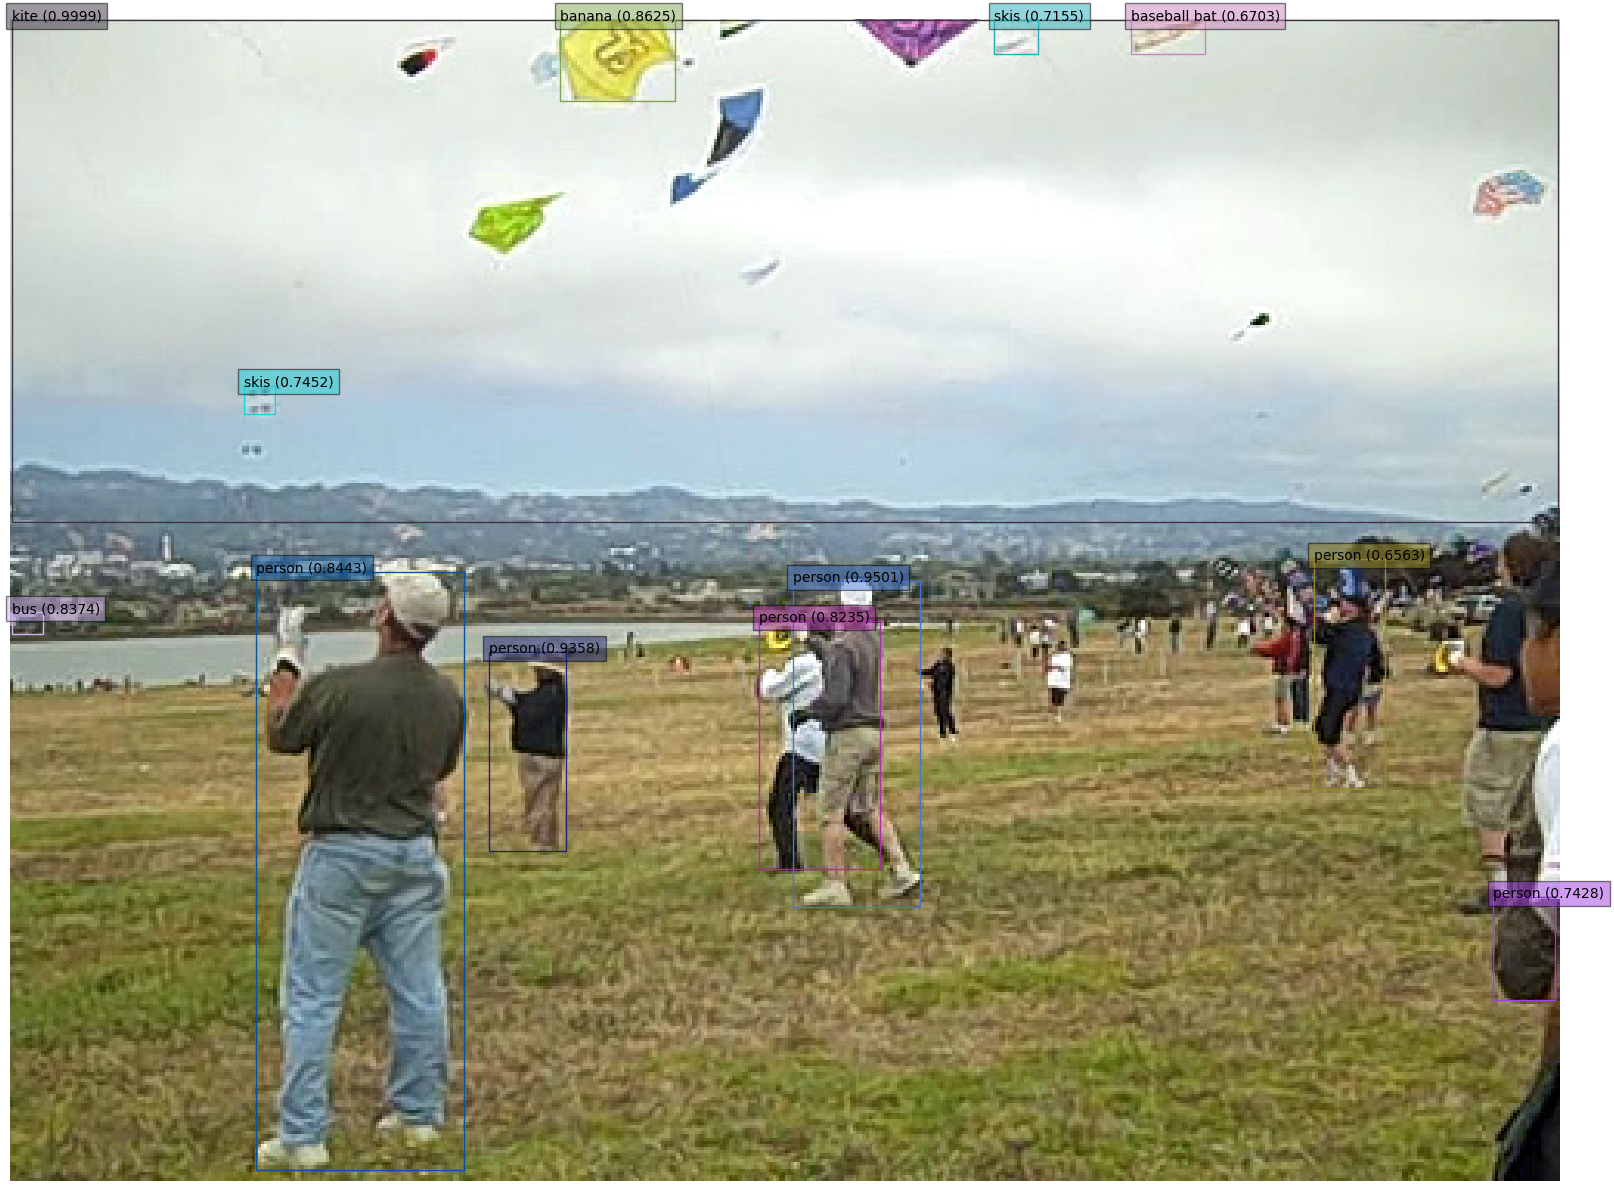

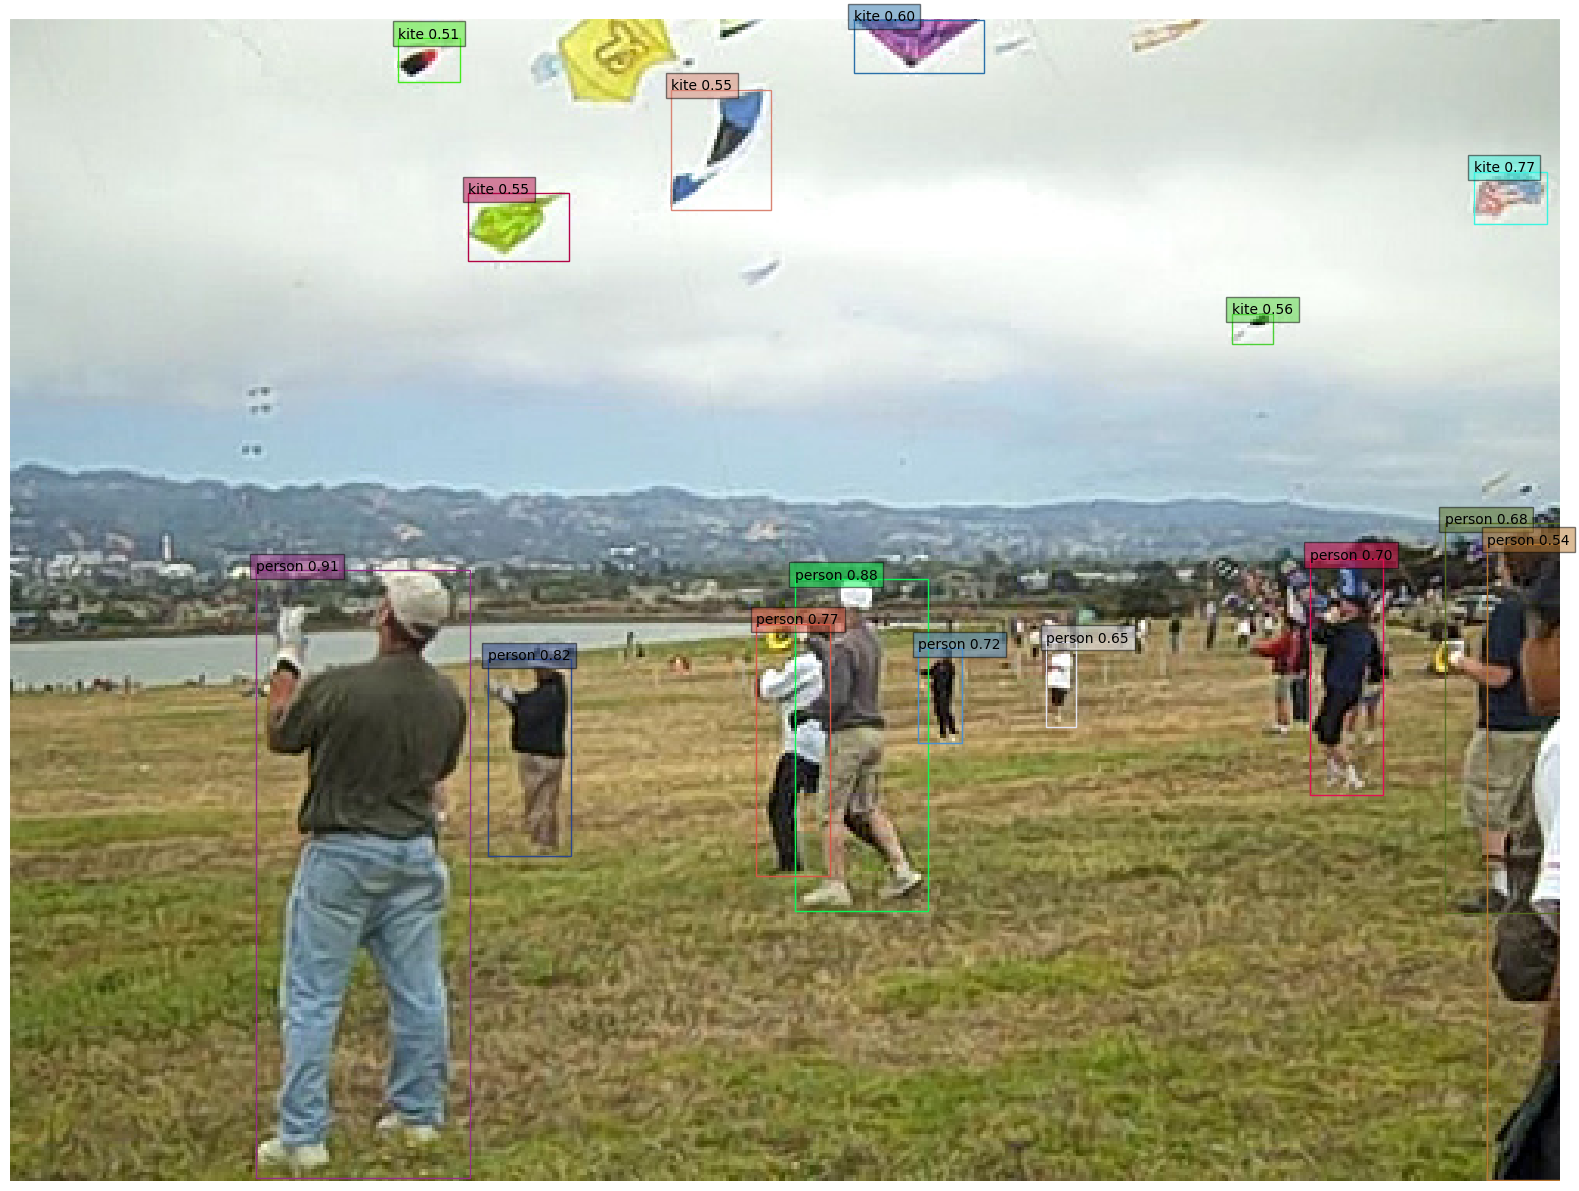

In [9]:
# ----------------------------------------
# Ground Truth
# ----------------------------------------
if not upload: # Stops ground truth code from executing if image is upload.

    image_number = random.randint(0,4999) # Choose an image from image 1 to image 5000 from the COCO2017 Validation data set.
    print(f"Image #{image_number} chosen.")
    print('Taking data from COCO2017 Validation Data Set and Displaying...')
    x = 0
    for img in images: # Get image.
        
        if x == image_number:
            sample_image_info = img
            break

        x += 1

    # Load image from COCO2017 Validation data set:
    print("Collecting data from URL...")
    request = urllib.request.Request(sample_image_info['coco_url'], headers={'User-Agent':'Mozilla/5,0'}) # prevent "forbidden" error.
    with urllib.request.urlopen(request) as url_response:
        img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
        image = cv2.imdecode(img_array, -1)
    print("COCO image loaded.")
    # Get bounding boxes of the ground truth:
    gt_annotations, gt_bboxes = validation_json['annotations'], []
    for annotation in gt_annotations:
        if annotation['image_id'] == img['id']:
            gt_bboxes.append(annotation)

    # Get the categories dictionary:
    categories = validation_json['categories']
    classes = {}

    for category in categories:
        classes[category['id']] = category['name']

    del categories # Free up some memory.

    # Plot ground truth image:
    plt.figure(figsize=(20,20))
    fig,ax = plt.subplots(1,figsize=(20,20))
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax.axis("off")

    for annotation in gt_bboxes: # Iterate over bounding boxes.
        x, y, w, h = annotation['bbox']
        x1, x2 = x, x + w
        y1, y2 = y, y + h
        color = np.random.rand(3,)
        rect = plt.Rectangle((x1,y1),w,h,fill=False,color=color)
        ax.add_patch(rect)
        color = np.append(color,0.5)
        ax.text(x1, y1, f"{classes[annotation['category_id']]}",color='black',fontsize = 10, bbox=dict(facecolor=color, alpha=0.5))  

# ----------------------------------------
# Create inference with SAM and OpenCLIP
# ----------------------------------------
print('Executing SAM + OpenCLIP Inference...')
masks = slice_and_classify(image)
fig2, ax2 = plt.subplots(1,figsize=(20,20))
ax2.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax2.axis("off")

for mask in masks:
    y1, y2, x1, x2 = mask['bbox']
    w, h = x2 - x1, y2 - y1
    label = mask['label']
    color = np.random.rand(3,)
    rect = plt.Rectangle((x1,y1),w,h,fill=False,color=color)
    ax2.add_patch(rect)
    color = np.append(color,0.5)
    ax2.text(x1, y1, f"{mask['label']}"+f" ({str(mask['confidence'])[:6]})",color='black',fontsize = 10, bbox=dict(facecolor=color, alpha=0.5)) 

# ----------------------------------------
# Creating an inference with the YOLO
# ----------------------------------------
print('Sending data to YOLOv8 Triton Server...')
with ModelClient(url="http://202.92.132.48:8000",model_name='Yolov8x') as client:

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    outputs = client.infer_sample(image)

    for k, v in outputs.items():
        if k == "names":
            names = v.tobytes().decode('utf-32').split("|")
            names = names[:-1]
        elif k == "bboxes":
            bboxes = v
        elif k == "probs":
            probs = v
    
fig3, ax3 = plt.subplots(1,figsize=(20,20))
ax3.imshow(image)
ax3.axis("off")

for i in range(len(names)):
    if probs[i] > 0.5:
        x1, y1, x2, y2 = bboxes[i]
        w = x2 - x1
        h = y2 - y1
        # make the color random
        color = np.random.rand(3,)
        rect = plt.Rectangle((x1, y1), w, h, fill=False, color=color)
        ax3.add_patch(rect)
        # use the color and add transparency of 0.5
        color = np.append(color, 0.5)
        # add text with white background
        ax3.text(x1, y1, f"{names[i]} {probs[i]:.2f}", color='black', fontsize=10, bbox=dict(facecolor=color, alpha=0.5))

# Validation:

According to Pycocotools, my performance is the following:

In [ ]:
"""
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.001
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.001
Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
"""

The following code bellow was used to get those results. Note that this Jupyter notebook is not intended to be used to validate the performace of this SAM + OpenCLIP zero-shot object detection algorithm.

In [ ]:
# Evaluation code start
# Note that this code is NOT meant to be run.
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import os

wd = os.getcwd()
annotations_file = os.path.join(wd,'annotations','instances_val2017.json')
coco_ground_truth = COCO(annotation_file=annotations_file)
results_file = os.path.join(wd,'converted_results.json')
coco_dt = coco_ground_truth.loadRes(results_file)
coco_eval = COCOeval(coco_ground_truth, coco_dt, 'bbox')

coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

Note that some pre-processing was needed in order to create this. The original tokenized labels was only 80 entries long but the validation json had indexes that ranged all the way to 90. Thus, another
data conversion was needed. The results.json file that was compiled was ran through the following code below to convert the 80 labels into the 90-label format:

In [ ]:
# Label ID converter.
# Note that this code is NOT meant to be run.
import json

with open('inferences.json','r') as file:
    original = json.load(file)

converter_dict = {
0: 1,
1: 2,
2: 3, 
3: 4, 
4: 5, 
5: 6, 
6: 7, 
7: 8, 
8: 9,
9: 10, 
10: 11,
11: 13, 
12: 14, 
13: 15,
14: 16, 
15: 17, 
16: 18, 
17: 19, 
18: 20, 
19: 21,
20: 22,
21: 23,
22: 24,
23: 25,
24: 27, 
25: 28,
26: 31,
27: 32, 
28: 33,
29: 34, 
30: 35, 
31: 36,
32: 37,
33: 38, 
34: 39, 
35: 40,
36: 41,
37: 42, 
38: 43, 
39: 44,
40: 46, 
41: 47, 
42: 48,
43: 49, 
44: 50,
45: 51,
46: 52,
47: 53, 
48: 54,
49: 55,
50: 56,
51: 57,
52: 58,
53: 59,
54: 60,
55: 61,
56: 62,
57: 63,
58: 64,
59: 65,
60: 67,
61: 70,
62: 72,
63: 73,
64: 74,
65: 75,
66: 76,
67: 77,
68: 78,
69: 79, 
70: 80,
71: 81,
72: 82,
73: 84,
74: 85,
75: 86,
76: 87,
77: 88,
78: 89,
79: 90}

array = []
for entry in original:
    d = entry
    d['category_id'] = converter_dict[entry['category_id']]
    array.append(d)

with open('converted_results.json','w') as file:
    json.dump(array,file)